<a href="https://colab.research.google.com/github/TAVAU/DS-Unit-2-Linear-Models/blob/master/DS_Sprint_Challenge_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [120]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

 
# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise 
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index. 

In [121]:
'''T1. Import DataFrame `df`'''

import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)
# YOUR CODE HERE
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [122]:
df.describe()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag,scoremargin_before_shot
count,1.395800e+04,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000
mean,2.442837e+07,270.438458,2.412380,4.727540,28.506376,17.600373,-0.554162,131.257988,0.472919,1.615561
std,7.226620e+06,169.927170,1.125828,3.331646,17.597701,10.295807,124.721869,102.666562,0.499284,10.127139
min,2.090002e+07,2.000000,1.000000,0.000000,0.000000,0.000000,-250.000000,-41.000000,0.000000,-39.000000
25%,2.120091e+07,109.000000,1.000000,2.000000,13.000000,8.000000,-96.000000,23.000000,0.000000,-4.000000
50%,2.150026e+07,275.500000,2.000000,4.000000,29.000000,22.000000,1.000000,141.000000,0.000000,1.000000
75%,2.170096e+07,398.000000,3.000000,7.000000,44.000000,25.000000,95.000000,219.000000,1.000000,8.000000
max,4.180040e+07,752.000000,6.000000,11.000000,59.000000,83.000000,247.000000,811.000000,1.000000,43.000000


In [123]:
type(df.index)

pandas.core.indexes.range.RangeIndex

**Task 1 Testing**

In [124]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above.

In [125]:
df.head(2)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0


In [126]:
"""T2. Create new feature"""

df['homecourt_advantage'] = df['htm'].apply(lambda x: 1 if x == 'GSW' else 0)
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,homecourt_advantage
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,1
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,1


**Task 2 Test**

In [127]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [128]:
'''T3. Create `X` and `y`.'''
target = 'shot_made_flag'
y = df[target]
X = df.drop(columns=target)

**Task 3 Test**

In [129]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Divide your dataset into training, validation, and test sets. 

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [130]:
df.head(2)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,homecourt_advantage
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,1


In [131]:
'''T4. Create training and val'''
# YOUR CODE HERE
df['game_date'].describe()

count          13958
unique           801
top       2013-05-06
freq              35
Name: game_date, dtype: object

In [132]:
X['game_date'] = pd.to_datetime(X['game_date'], format='%Y-%m-%d')
df['game_date'] = pd.to_datetime(df['game_date'], format='%Y-%m-%d')

In [133]:
X_train = X[(X['game_date'] >= pd.to_datetime('2009-10-01')) & (X['game_date'] < pd.to_datetime('2017-07-01'))]
y_train = df[(df['game_date'] >= pd.to_datetime('2009-10-01')) & (df['game_date'] < pd.to_datetime('2017-07-01'))][target]
X_val = X[(X['game_date'] >= pd.to_datetime('2017-10-01')) & (X['game_date'] < pd.to_datetime('2018-07-01'))]
y_val = df[(df['game_date'] >= pd.to_datetime('2017-10-01')) & (df['game_date'] < pd.to_datetime('2018-07-01'))][target]

X_test = X[(X['game_date'] >= pd.to_datetime('2018-10-01')) & (X['game_date'] < pd.to_datetime('2019-07-01'))]
y_test = df[(df['game_date'] >= pd.to_datetime('2018-10-01')) & (df['game_date'] < pd.to_datetime('2019-07-01'))][target]


In [134]:
df = X_test
print(df.index.min())
print(df.index.max())

12249
13957


**Test 4**

In [135]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [137]:
#target = 'shot_made_flag'
y_train.value_counts(normalize=True)

0    0.527209
1    0.472791
Name: shot_made_flag, dtype: float64

In [138]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [139]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''
from sklearn.metrics import accuracy_score
baseline_acc = accuracy_score(y_train, y_pred)
# YOUR CODE HERE
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [140]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [146]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [148]:
numeric_features = X_train.select_dtypes(include='number').columns.tolist()
cardinality = X_train.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
features = numeric_features + categorical_features
features


['game_id',
 'game_event_id',
 'period',
 'minutes_remaining',
 'seconds_remaining',
 'shot_distance',
 'loc_x',
 'loc_y',
 'scoremargin_before_shot',
 'homecourt_advantage',
 'player_name',
 'shot_type',
 'shot_zone_basic',
 'shot_zone_area',
 'shot_zone_range',
 'htm',
 'vtm',
 'season_type']

In [150]:
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [151]:
model = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(random_state=42)
)

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['player_name', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': Stephen Curry    1
NaN             -2
dtype: int64},
                                         {'col': 'shot_typ...
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
         

**Task 6 Testing**

In [152]:
'''T6 Testing'''

import sklearn
assert isinstance(model, sklearn.pipeline.Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [153]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.5231164383561644


**Task 7 Test**

In [154]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`. 
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [157]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

In [181]:
'''T8. Tune model.'''
model = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=42)
)
param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000), 
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
}
search = RandomizedSearchCV(
    model, 
    param_distributions=param_distributions, 
    n_iter=3, 
    cv=None, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [174]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 0.39370983649766256, 'randomforestregressor__n_estimators': 292, 'simpleimputer__strategy': 'mean', 'targetencoder__min_samples_leaf': 724}
Cross-validation MAE 0.4811668466789795


In [183]:
pipeline = search.best_estimator_

In [186]:
from sklearn.metrics import mean_absolute_error

y_pred = pipeline.predict(X_test)
test_acc = mean_absolute_error(y_test, y_pred)
print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.48275374124684006


**Task 8 Testing**

In [187]:
'''T8 Testing'''

assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

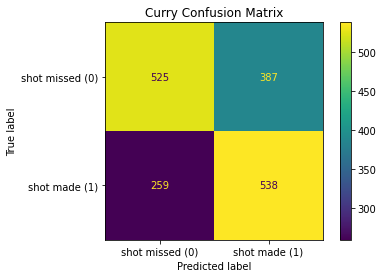

In [171]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
instructor_precision = 538 / (538 + 387)
instructor_recall = 538 / (538 + 259)
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


**Task 9 Testing**

In [172]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**. Does your model have higher recall or higher precision? How does your model's metrics compare to the metrics you calculated above?

In [ ]:
'''T10. Plot ROC curve.'''
# YOUR CODE HERE
raise NotImplementedError()